##  0.0. Objetivo do Problema:


-- 1.0. Previsao do primeiro destino que um novo usuário irá escolher.

-- Porque?
    -- Qual tipo de modelo de negócio do Airbnb? 
    
    
        - Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta ( pessoas oferecendo acomodacao )
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio

        - Demanda ( pessoas procurando acomodacao )
            - Numero de Usuários
            - LTV ( Lifetime Value )
            - CAC ( Client Acquisition Cost )


           Gross Revenue = ( Fee * Numero cliente ) - CAC 

##  0.1. Proposta de solução:


--- Modelo de Predizao do primeiro destino de um novo usario.

- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
        --- Input: usuario e suas caracteristicas
        --- Output: usuario e suas caracteristicas com a **predicao do destino**

--- 16 ciclos

# <font color ='red'> 1.0. Imports </font> 

In [64]:
import random
import pandas                               as pd
import seaborn                              as sns
import numpy                                as np
import matplotlib.pyplot                    as plt

from sklearn      import model_selection    as ms
from sklearn      import preprocessing      as pp
from sklearn      import metrics            as m

from scikitplot   import metrics            as mt
from scipy        import stats              as ss


from keras        import models             as ml
from keras        import layers             as l

from IPython.core.display          import HTML

import warnings

warnings.filterwarnings("ignore")



## 1.1. Helper Function

In [37]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
    
my_settings()

In [66]:
 # correlation 2 categorical variables 
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 1.2. Loading Data

In [2]:
df_raw = pd.read_csv('~/repositorio/airbnb_predict/data/raw/train_users_2.csv', low_memory=True)
df_sessions = pd.read_csv('~/repositorio/airbnb_predict/data/raw/sessions.csv', low_memory=True)

# 2.0. Data Description


In [3]:
df2 = df_raw.copy()

In [4]:
print('Number of rows: {}'.format(df2.shape[0]))
print('Number of columns: {}'.format(df2.shape[1]))

Number of rows: 213451
Number of columns: 16


In [5]:
print('Number of rows: {}'.format(df_sessions.shape[0]))
print('Number of columns: {}'.format(df_sessions.shape[1]))

Number of rows: 10567737
Number of columns: 6


## 2.1. Data Type


In [6]:
df2.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [7]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 2.2. NA Check


In [8]:
df2.isna().sum() / len(df2)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [9]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [10]:
# aux = df_sessions[df_sessions['secs_elapsed'] < 0.25e6]

In [11]:
# sns.distplot(aux['secs_elapsed'])

In [12]:
# sns.distplot(df2[df2['age'] < 65] ['age'])

In [13]:
# remove missing value completly

# df2 = df2.dropna()

# ==================== User ======================
# date_first_booking
date_first_booking_max = pd.to_datetime(df2['date_first_booking']).max().strftime('%Y%m%d')
df2['date_first_booking'] = df2['date_first_booking'].fillna(date_first_booking_max)
                                
# age
avg_age = df2['age'].mean()   
df2['age'] = df2['age'].fillna(avg_age)

# first_affiliate_tracked
df2 = df2[~df2['first_affiliate_tracked'].isna()]     

# ==================== Sessions ======================
# user_id          0.003 %
df_sessions = df_sessions[~df_sessions['user_id'].isna()]     

# action           0.007 %
df_sessions = df_sessions[~df_sessions['action'].isna()]     

# action_type      0.106 %
df_sessions = df_sessions[~df_sessions['action_type'].isna()]     

# action_detail    0.106 %
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]     

# device_type      0.000 %
df_sessions = df_sessions[~df_sessions['device_type'].isna()]     

# secs_elapsed     0.012 %
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]     


                                

## 2.3. Change Data Type


In [14]:
# 'date_account_created'
df2['date_account_created'] = pd.to_datetime(df2['date_account_created'])

# 'timestamp_first_active'
df2['timestamp_first_active'] = pd.to_datetime(df2['timestamp_first_active'], format = '%Y%m%d%H%M%S')

# 'date_first_booking'
df2['date_first_booking'] = pd.to_datetime(df2['date_first_booking'])

# 'age'
df2['age'] = df2['age'].astype('int64')


## 2.4. Check Balanced Data


In [15]:
df2['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 2.5. Descriptive Analysis

In [42]:

#====================== Users ===========================
num_att = df2.select_dtypes(include = ['int64','float64'])
cat_att = df2.select_dtypes(exclude = ['int64','float64', 'datetime64[ns]'])
time_att = df2.select_dtypes(include = ['datetime64[ns]'])

#==================== Sessions ==========================
num_att_sessions = df_sessions.select_dtypes(include = ['int64','float64'])
cat_att_sessions = df_sessions.select_dtypes(exclude = ['int64','float64', 'datetime64[ns]'])
time_att_sessions = df_sessions.select_dtypes(include = ['datetime64[ns]'])


### 2.5.1 Numerical - Users

In [45]:
# Central tendency - mean , median
ct1 = pd.DataFrame(num_att.apply(np.mean)).T
ct2 = pd.DataFrame(num_att.apply(np.median)).T

# Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame(num_att.apply(np.std)).T
d2 = pd.DataFrame(num_att.apply(min)).T
d3 = pd.DataFrame(num_att.apply(max)).T
d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns =['attributes','min','max','range','mean','median','std','skew','kustosis']
m

,attributes,min,max,range,mean,median,std,skew,kustosis
0,age,1.00,2014.00,2013.00,49.18,49.00,118.42,16.33,267.66
1,signup_flow,0.00,25.00,25.00,3.15,0.00,7.54,2.29,3.57


### 2.5.1 Numerical - Sessions

In [47]:
# Central tendency - mean , median
ct1 = pd.DataFrame(num_att_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_att_sessions.apply(np.median)).T

# Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame(num_att_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_att_sessions.apply(min)).T
d3 = pd.DataFrame(num_att_sessions.apply(max)).T
d4 = pd.DataFrame(num_att_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_att_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_att_sessions.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns =['attributes','min','max','range','mean','median','std','skew','kustosis']
m

,attributes,min,max,range,mean,median,std,skew,kustosis
0,secs_elapsed,0.00,1799977.00,1799977.00,19961.83,1369.00,88849.39,11.14,154.84


### 2.5.3 Categorical - Users

In [49]:
cat_att.drop('id', axis = 1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


### 2.5.4 Categorical - Sessions

In [52]:
cat_att_sessions.drop('user_id', axis = 1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [67]:
# list of atrributes for Cramer's V correlation

cat_att_list = cat_att_sessions.drop('user_id',axis = 1).columns.to_list()

corr_dict = {}

for i in range(len(cat_att_list)):
    corr_list = []
    for j in range(len(cat_att_list)):
        ref  = cat_att_list[i]
        feat = cat_att_list[j]
        corr = cramer_v(cat_att_sessions[ref], cat_att_sessions[feat])
        corr_list.append(corr)
        
        corr_dict[ref] = corr_list

<AxesSubplot:>

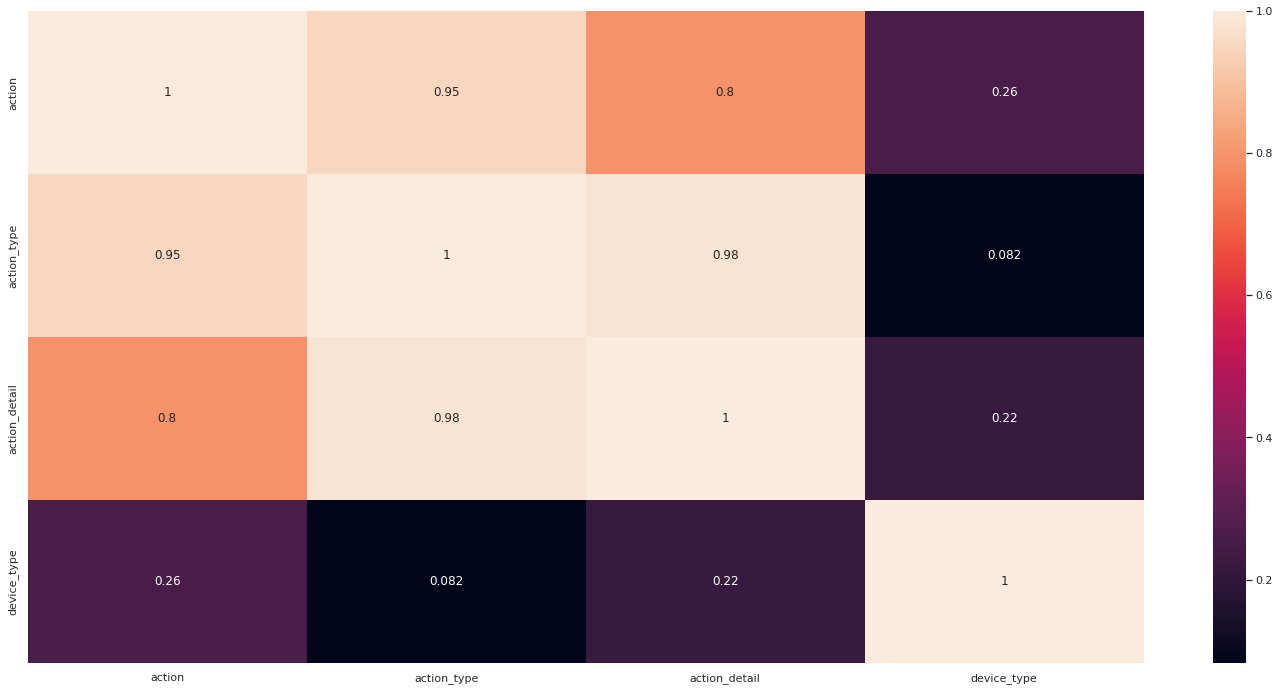

In [73]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d , annot= True)

# 3.0.  Feature Engineering


In [75]:
df3 = df2.copy()

## 3.1. Create New Features

In [76]:
# days from first active up to first booking
df3['first_active'] = pd.to_datetime( df3['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df3['days_from_frist_active_until_booking'] = (  e_first_booking'] - df3['first_active'] ).apply( lambda x: x.days )

# days from first active upt to account created
df3['days_from_first_active_until_account_created'] = ( df3['date_account_created'] - df3['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df3['days_from_account_created_until_first_booking'] = ( df3['date_first_booking'] - df3['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df3['year_first_active'] = df3['first_active'].dt.year

# month first active
df3['month_fist_active'] = df3['first_active'].dt.month

# day first active
df3['day_first_active'] = df3['first_active'].dt.day

# day of week first active
df3['day_of_week_first_active'] = df3['first_active'].dt.dayofweek

# week of year first active
df3['week_of_year_first_active'] = df3['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df3['year_first_booking'] = df3['date_first_booking'].dt.year

# month first booking
df3['month_first_booking'] = df3['date_first_booking'].dt.month

# day first booking
df3['day_first_booking'] = df3['date_first_booking'].dt.day

# day of week first booking
df3['day_of_week_first_booking'] = df3['date_first_booking'].dt.dayofweek

# week of year first booking
df3['week_of_year_first_booking'] = df3['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df3['year_account_created'] = df3['date_account_created'].dt.year

# month  account_created
df3['month_account_created'] = df3['date_account_created'].dt.month

# day  account_created
df3['day_account_created'] = df3['date_account_created'].dt.day

# day of week  account_created
df3['day_of_week_account_created'] = df3['date_account_created'].dt.dayofweek

# week of year  account_created
df3['week_of_year_account_created'] = df3['date_account_created'].dt.weekofyear

In [78]:
df3.shape

(206593, 35)

# 4.0.  Data Filtering


In [79]:
df4 = df3.copy()

## 4.1.  Filtering Rows


In [80]:
# age - greater than 15 and lower than 120 - There are few peoples over 120 years old
df4 = df4[(df2['age'] > 15 ) & (df4['age'] < 120)]

# secs_elapsed - There is no possible 0 elapsed in the site
df_sessions = df_sessions[df_sessions['secs_elapsed'] > 0]

## 4.2.  Columns Selection

# 5.0.  Data Preparation


In [81]:
df5 = df4.copy()

In [82]:
# dummy variable
df5_dummy = pd.get_dummies(df5.drop(['id','country_destination'], axis =1))

# join id and country destination
df5 = pd.concat([df4[['id','country_destination']],df5_dummy], axis =1)

# 6.0. Feature Selection


In [83]:
df6 = df5.copy()

In [84]:
cols_drop = ['date_account_created','timestamp_first_active','date_first_booking', 'first_active'] # original dates

In [85]:
df6 = df6.drop(cols_drop, axis =1)

In [86]:
X = df6.drop(['id','country_destination'], axis = 1)
Y = df6['country_destination'].copy()

In [87]:
# Split dataset into training and test

X_train, X_test , y_train, y_test = ms.train_test_split(X, Y, test_size = 0.2 , random_state=32)

# 7.0. Machine Learning Model


In [88]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

## 6.1. Baseline Model


In [89]:
country_destination_list = df5['country_destination'].drop_duplicates().sort_values().to_list()
k_num = y_test.shape[0]
country_destination_weights = df5['country_destination'].value_counts(normalize= True).sort_index().to_list()

# modelo aleatorio
yhat_random = random.choices (population = country_destination_list , 
                              weights = country_destination_weights,
                              k = k_num )

### 6.1.1 Performance


Accuracy: 0.4250586897069145
Balanced Accuracy: 0.08532773069314241
Kappa Score: 0.000528557747749514


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

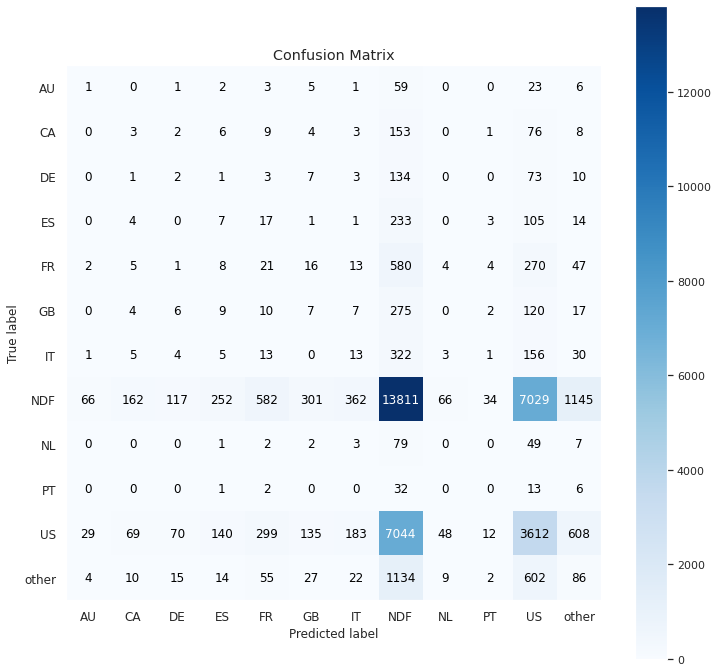

In [90]:
# accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_acc_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_acc_random))

# confusion matrix
mt.plot_confusion_matrix(y_test , yhat_random, normalize=False, figsize=(12,12))

## 6.2. Neural Network - MLP

In [93]:
X_train.shape

(165274, 150)

In [ ]:
# model definition
model = ml.Sequential()
model.add(l.Dense(256, input_dim = X_train.shape[1], activation= 'relu'))
model.add(l.Dense(12,  activation= 'softmax'))

# model compile
model.compile(loss = 'categorical_crossentropy' , optimizer='adam', metrics=['accuracy'])

# tain model
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
5165/5165 [==============================] - 8s 2ms/step - loss: 4.0167 - accuracy: 0.7943
Epoch 2/100
5165/5165 [==============================] - 8s 2ms/step - loss: 1.0474 - accuracy: 0.8327
Epoch 3/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.5744 - accuracy: 0.8664
Epoch 4/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.5068 - accuracy: 0.8718
Epoch 5/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4998 - accuracy: 0.8729
Epoch 6/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4976 - accuracy: 0.8732
Epoch 7/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4971 - accuracy: 0.8732
Epoch 8/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4971 - accuracy: 0.8733
Epoch 9/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4963 - accuracy: 0.8734
Epoch 10/100
5165/5165 [==============================] - 7s 1ms/step - l

### 6.2.1 NN Performance


In [ ]:
# prediction
pred_nn = model.predict(X_test)

# invert Predict
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

In [ ]:
# accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_acc_nn))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn , yhat_nn, normalize=False, figsize=(12,12))

### 6.2.2 NN Performance - Cross Validation


In [ ]:
# gerate k-fold

num_fold = 5
kfold = ms.StratifiedKFold ( n_splits = num_fold , shuffle = True, random_state = 32 )

balanced_acc_list = []
kappa_acc_nn_list = []

i = 1
for train_ix , val_ix in kfold.split (X_train, y_train):
    print(' Fold Number : {}/{}'.format(i, num_fold))
    # get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoging
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()
     
    # model definition
    model = ml.Sequential()
    model.add(l.Dense(256 , input_dim =X_train.shape[1] , activation = 'relu' ))
    model.add(l.Dense(11 , activation = 'softmax' ))

    # compile model
    model.compile ( loss = 'categorical_crossentropy', optimizer = 'adam' , metrics=['accuracy'])

    # training model
    model.fit( x_train_fold , y_train_fold_nn, epochs = 100, batch_size = 32, verbose = 0)
    
    # prediction
    pred_nn = model.predict(x_val_fold)

    # invert Predict
    yhat_nn = ohe.inverse_transform(pred_nn)

    #  prepare data
    y_test_nn =y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1,-1)[0]    
    
    # metrics
    # Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    # Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_nn_list.append(kappa_acc_nn)

    i +=  1

In [ ]:
print ("Avg Balanced Acurracy : {} +/- {}".format(np.round(np.mean(balanced_acc_list),2), 
                                                  np.round(np.std(balanced_acc_list),4 )))

print ("Avg Kappa Score : {} +/- {}".format(np.round(np.mean(kappa_acc_nn_list),3), 
                                            np.round(np.std(kappa_acc_nn_list),4 )))